# Load LSTM Models
This notebook is for training LSTM models to forecast energy demand in NYISO for its various regions.

Input Data:
- data without fuel mix

We can start by importing the modules we need.

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout 
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
from sklearn.preprocessing import MaxAbsScaler

Now we can load in our data. All preprocessing and cleaning has already been done.

In [3]:
###############################################################################################################################
    # LOAD AND PROCESS DATA
##############################################################################################################################

train_part1 = pd.read_parquet('../../../data/train_data_without_fuelmix_part1.parquet')
train_part2 = pd.read_parquet('../../../data/train_data_without_fuelmix_part2.parquet')
test_part1 = pd.read_parquet('../../../data/test_data_without_fuelmix_part1.parquet')
test_part2 = pd.read_parquet('../../../data/test_data_without_fuelmix_part2.parquet')

# Concatenate the parts
train_data = pd.concat([train_part1, train_part2])
test_data = pd.concat([test_part1, test_part2])


# Segment data by region
regions = train_data['Region'].unique()  # Get unique regions

# Create a dictionary to hold training and testing data for each region
region_datasets = {region: {'train': None, 'test': None} for region in regions}
region_unscaled_datasets = {region: {'train': None, 'test': None} for region in regions}
for region in regions:
    # Filter the training and testing datasets for the current region
    region_train = train_data[train_data['Region'] == region]
    region_test = test_data[test_data['Region'] == region]
    
    # Normalize features for each region separately
    columns_to_drop = ['Load', 'name', 'Name', 'Region', 'LBMP ($/MWHr)_min', 'LBMP ($/MWHr)_mean', 'LBMP ($/MWHr)_max', 'severerisk']
    features_train = region_train.drop(columns=columns_to_drop)
    target_train = region_train['Load']
    features_test = region_test.drop(columns=columns_to_drop)
    target_test = region_test['Load']

    #reset index
    features_train.reset_index(inplace=True)
    features_test.reset_index(inplace=True)

    #convert time stamp to sin values
    date_time_train = pd.to_datetime(features_train.pop('Time Stamp'), format='%d.%m.%Y %H:%M:%S')
    timestamp_s_train = date_time_train.map(pd.Timestamp.timestamp)

    date_time_test = pd.to_datetime(features_test.pop('Time Stamp'), format='%d.%m.%Y %H:%M:%S')
    timestamp_s_test = date_time_test.map(pd.Timestamp.timestamp)


    day = 24*60*60
    year = (365.2425)*day

    features_train['Day sin'] = np.sin(timestamp_s_train * (2 * np.pi / day))
    features_train['Year sin'] = np.sin(timestamp_s_train * (2 * np.pi / year))

    features_test['Day sin'] = np.sin(timestamp_s_test * (2 * np.pi / day))
    features_test['Year sin'] = np.sin(timestamp_s_test * (2 * np.pi / year))

    # drop the time categories
    cats_to_drop = ['Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4',
        'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11',
        'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17',
        'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23',
        'DayOfWeek_0', 'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'MonthOfYear_1',
       'MonthOfYear_2', 'MonthOfYear_3', 'MonthOfYear_4', 'MonthOfYear_5',
       'MonthOfYear_6', 'MonthOfYear_7', 'MonthOfYear_8', 'MonthOfYear_9',
       'MonthOfYear_10', 'MonthOfYear_11', 'MonthOfYear_12', 'WeekNumber_1',
       'WeekNumber_2', 'WeekNumber_3', 'WeekNumber_4', 'WeekNumber_5',
       'WeekNumber_6', 'WeekNumber_7', 'WeekNumber_8', 'WeekNumber_9',
       'WeekNumber_10', 'WeekNumber_11', 'WeekNumber_12', 'WeekNumber_13', 
       'WeekNumber_14', 'WeekNumber_15', 'WeekNumber_16', 'WeekNumber_17', 
       'WeekNumber_18', 'WeekNumber_19', 'WeekNumber_20',
       'WeekNumber_21', 'WeekNumber_22', 'WeekNumber_23', 'WeekNumber_24',
       'WeekNumber_25', 'WeekNumber_26', 'WeekNumber_27', 'WeekNumber_28',
       'WeekNumber_29', 'WeekNumber_30', 'WeekNumber_31', 'WeekNumber_32',
       'WeekNumber_33', 'WeekNumber_34', 'WeekNumber_35', 'WeekNumber_36',
       'WeekNumber_37', 'WeekNumber_38', 'WeekNumber_39', 'WeekNumber_40',
       'WeekNumber_41', 'WeekNumber_42', 'WeekNumber_43', 'WeekNumber_44',
       'WeekNumber_45', 'WeekNumber_46', 'WeekNumber_47', 'WeekNumber_48',
       'WeekNumber_49', 'WeekNumber_50', 'WeekNumber_51', 'WeekNumber_52',
       'WeekNumber_53']
    features_train.drop(columns = cats_to_drop, inplace=True)
    features_test.drop(columns = cats_to_drop, inplace=True)

    # Convert to radians
    wd_rad_train = features_train.pop('winddir')*np.pi / 180
    wd_rad_test = features_test.pop('winddir')*np.pi / 180

    # Calculate the wind x and y components
    features_train['Wx'] = features_train['windspeed']*np.cos(wd_rad_train)
    features_train['Wy'] = features_train['windspeed']*np.sin(wd_rad_train)

    # Calculate the wind x and y components
    features_test['Wx'] = features_test['windspeed']*np.cos(wd_rad_test)
    features_test['Wy'] = features_test['windspeed']*np.sin(wd_rad_test)


    dummy_features = ['condition_Clear', 'condition_Fog',
        'condition_Freezing Drizzle/Freezing Rain', 'condition_Ice',
        'condition_Overcast', 'condition_Partially cloudy', 'condition_Rain',
        'condition_Snow', 'preciptype_freezingrain', 'preciptype_ice',
        'preciptype_rain', 'preciptype_snow']

    region_unscaled_datasets[region]['train'] = (features_train, target_train)
    region_unscaled_datasets[region]['test'] = (features_test, target_test)
    # Scale features using maxabsscaler scaling
    scaler = MaxAbsScaler()
    numerical_columns = [column for column in features_train.columns if column not in dummy_features]

    #get numerical subset
    features_train_numerical = features_train.loc[:, numerical_columns]
    features_test_numerical = features_test.loc[:, numerical_columns]
    #get categorical subset
    categorical_train = features_train.loc[:,dummy_features]
    categorical_test = features_test.loc[:, dummy_features]

    features_train_scaled = scaler.fit_transform(features_train_numerical)
    features_test_scaled = scaler.transform(features_test_numerical)

    features_train_scaled = np.hstack((features_train_scaled, categorical_train))
    features_test_scaled = np.hstack((features_test_scaled, categorical_test))

    # Convert to sequences
    def create_sequences(features, target, sequence_length):
        xs = []
        ys = []
        for i in range(len(features) - sequence_length):
            xs.append(features[i:(i + sequence_length)])
            ys.append(target[i + sequence_length])
        return np.array(xs), np.array(ys)

    # Create sequences
    sequence_length = 4
    X_train, y_train = create_sequences(features_train_scaled, target_train.values, sequence_length)
    X_test, y_test = create_sequences(features_test_scaled, target_test.values, sequence_length)
    
    # Store in dictionary
    region_datasets[region]['train'] = (X_train, y_train)
    region_datasets[region]['test'] = (X_test, y_test)

##############################################################################################################################
    # BUILD LSTM MODEL
##############################################################################################################################

def build_model(sequence_length, n_features):
    model = Sequential([
        LSTM(10, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l1(.5), 
             recurrent_dropout=0.2, return_sequences=False, input_shape=(sequence_length, n_features)),
        BatchNormalization(),
        Dropout(0.2),  # Add dropout regularization
        # LSTM(32, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(.01), 
        #      recurrent_dropout=0.2, return_sequences=False, input_shape=(sequence_length, n_features)),
        # BatchNormalization(),
        # Dropout(0.2),  # Add dropout regularization
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),  # Add dropout regularization
        Dense(1, activation='linear')
    ])

     

    # explicit loss functio
    loss_fn = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size') 
    
    # Define a learning rate schedule
    initial_learning_rate = 0.01
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=1000,
        decay_rate=0.9,
        staircase=True)

    # explicit optimizer
    optimizer = tf.keras.optimizers.legacy.Adam(clipvalue=1,learning_rate=lr_schedule)

    model.compile(optimizer=optimizer, loss=loss_fn)
    return model

##############################################################################################################################
    # TRAIN AN LSTM MODEL PER REGION
##############################################################################################################################

# Define a dictionary to keep track of the best validation loss for each region
best_val_loss = {region: float('inf') for region in region_datasets.keys()}

# Iterate over regions and train models
for region, datasets in list(region_datasets.items()):
    X_train, y_train = datasets['train']
    X_test, y_test = datasets['test']
    n_features = X_train.shape[2] # Number of features is the second dimension of X_train
    
    model = build_model(sequence_length, n_features) # Build the model for the current region

    # initial_learning_rate = 0.1 # Initial learning rate
    # decay_factor = 0.5 # Factor to decrease the learning rate
    # step_size = 10 # Step size: the learning rate will be reduced every 'step_size' epochs

    # def step_decay(epoch):
    #     return initial_learning_rate * (decay_factor ** (epoch // step_size))

    # lr_schedule = tf.keras.callbacks.LearningRateScheduler(step_decay) # Define the LearningRateScheduler callback with the step_decay function
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    class LearningRatePrinter(Callback):
        def on_epoch_begin(self, epoch, logs=None):
            lr = self.model.optimizer.learning_rate(tf.cast(self.model.optimizer.iterations, tf.int64))
            print(f"Learning rate for epoch {epoch + 1}: {lr.numpy()}")

    # Define a ModelCheckpoint callback to save the best performing model for each region
    checkpoint_callback = ModelCheckpoint(
        filepath=os.path.join('load_lstm_models', f'{region}_load_lstm_model.keras'),
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode='min',
        save_freq='epoch'
    )
    
    # Train the model with ModelCheckpoint callback
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=96,
        validation_split=0.2,
        callbacks=[checkpoint_callback, early_stopping, LearningRatePrinter()], 
        shuffle=True,
        verbose=1
    )

    # After model training, evaluate the model using validation data and calculate evaluation metrics
    print(f"\nModel Evaluation for {region}:")
    evaluation_metrics = model.evaluate(X_test, y_test)

    # Update the best validation loss for the current region
    best_val_loss[region] = min(best_val_loss[region], min(history.history['val_loss']))



Learning rate for epoch 1: 0.009999999776482582
Epoch 1/20

950/972 [============================>.] - ETA: 0s - loss: 477650.8750
Epoch 1: val_loss improved from inf to 13848.74316, saving model to load_lstm_models\CAPITL_load_lstm_model.keras
972/972 [==============================] - 4s 2ms/step - loss: 467426.1250 - val_loss: 13848.7432
Learning rate for epoch 2: 0.009999999776482582
Epoch 2/20
954/972 [============================>.] - ETA: 0s - loss: 20333.0645
Epoch 2: val_loss did not improve from 13848.74316
972/972 [==============================] - 2s 2ms/step - loss: 20307.2793 - val_loss: 15668.5850
Learning rate for epoch 3: 0.008999999612569809
Epoch 3/20
963/972 [============================>.] - ETA: 0s - loss: 19343.1094
Epoch 3: val_loss did not improve from 13848.74316
972/972 [==============================] - 2s 2ms/step - loss: 19338.7129 - val_loss: 14620.5537
Learning rate for epoch 4: 0.008099999278783798
Epoch 4/20
953/972 [============================>.] - 

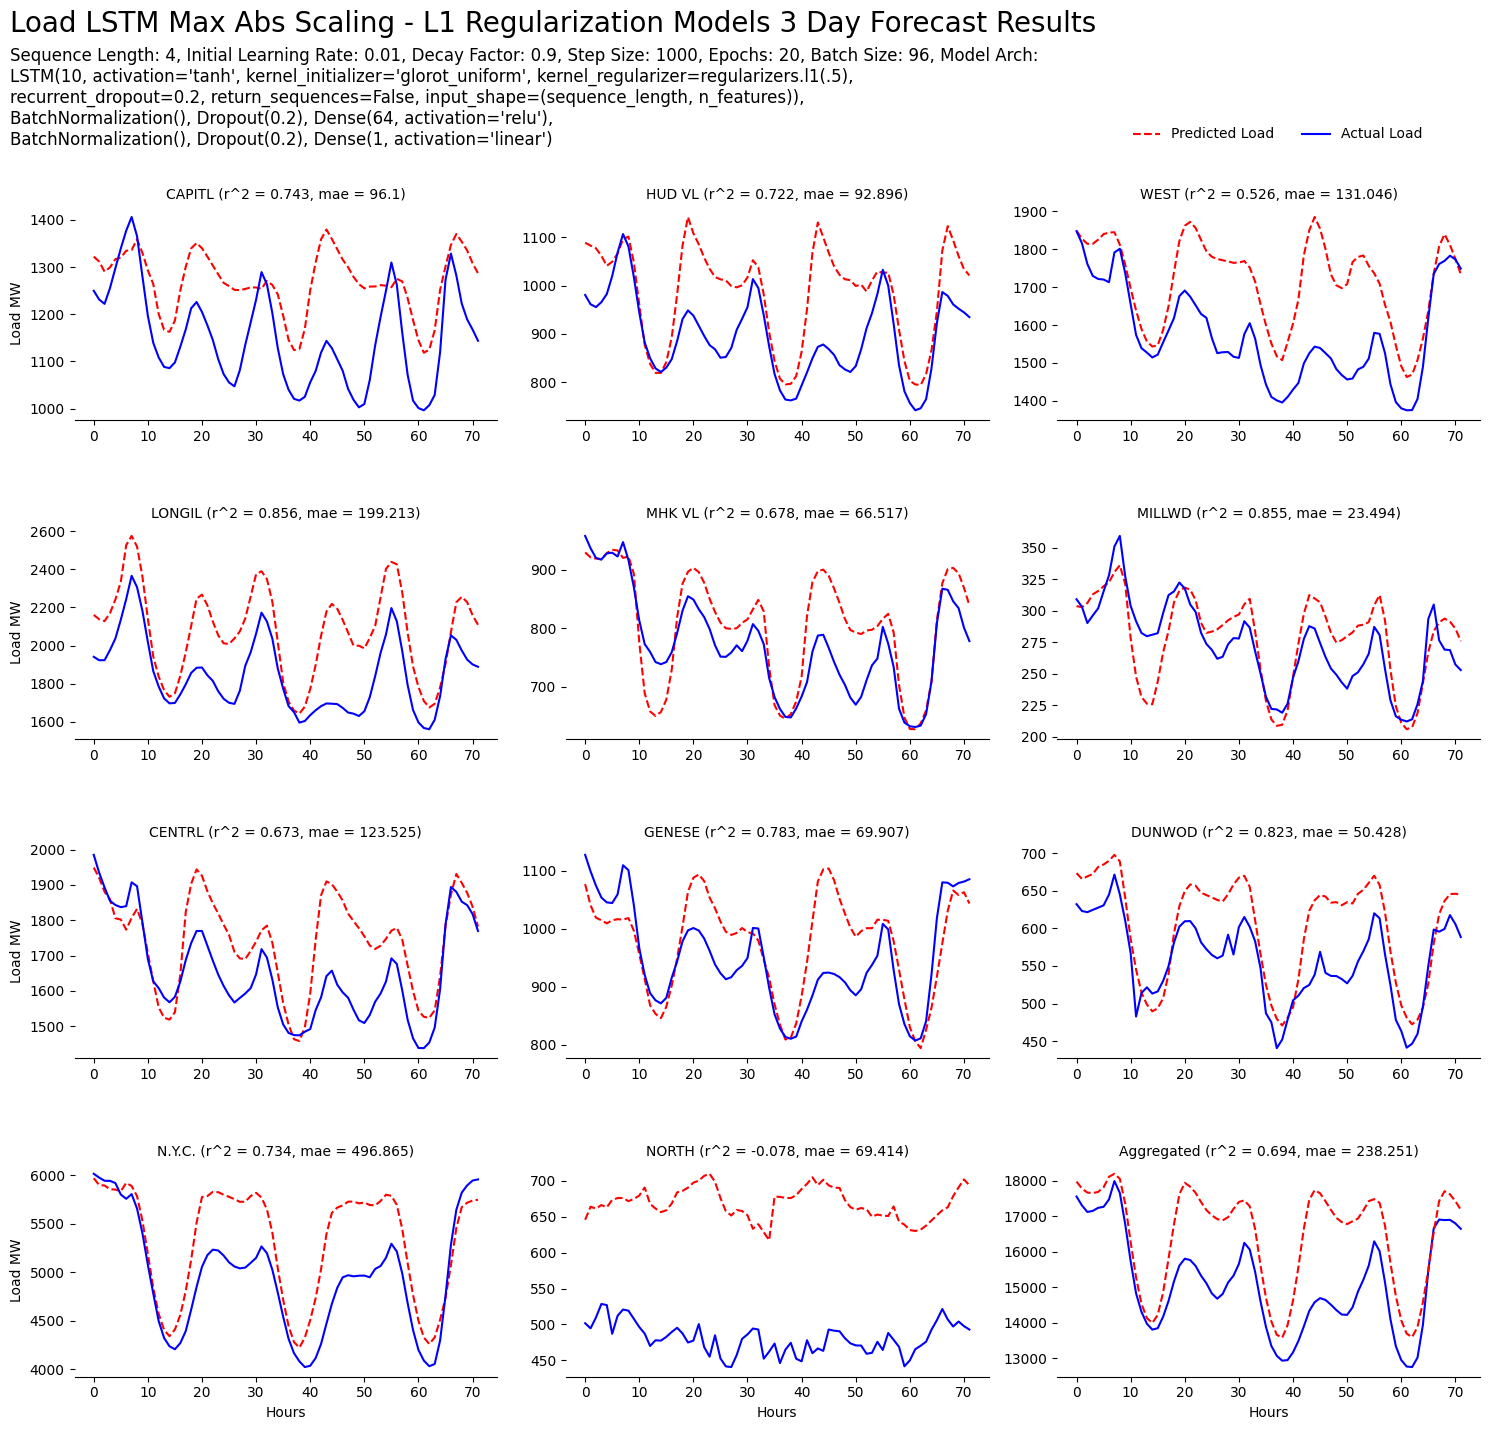

In [4]:

# Define the size of the grid
rows, cols = 4, 3
fig, axs = plt.subplots(rows, cols, figsize=(15, 15))  # Adjust the figure size as needed
axs = axs.flatten() # Flatten the array of axes to easily iterate over it

n = 72  # Number of samples to visualize, adjust as needed
aggregated_actual = np.zeros(n)
aggregated_predictions = np.zeros(n)
all_predictions = []

r2_scores = {}
mae_scores = {}

for i, (region, datasets) in enumerate(region_datasets.items()):
    X_test, y_test = datasets['test']  # Retrieve the test dataset for the current region
    
    # Load the trained model for the current region
    model = build_model(sequence_length, X_test.shape[2])  # Assuming sequence_length and n_features are defined
    model.load_weights(f'load_lstm_models/{region}_load_lstm_model.keras')  # Load the best saved model
    
    # Make predictions
    predictions = model.predict(X_test, verbose=0)

    # Capture mse and r2
    mae = mean_absolute_error(y_test, predictions)
    mae_scores[region] = mae
    r2 = r2_score(y_test, predictions)
    r2_scores[region] = r2

    # Sum across index for aggregated data
    aggregated_actual += y_test[:n]
    aggregated_predictions += predictions[:n].flatten()  # Flatten in case predictions have an extra dimension
    all_predictions.append(sum(sum(predictions[:n])))

    # Plotting actual vs. predictions for the first 'n' test samples in the ith subplot
    axs[i].plot(predictions[:n], label='Predicted Load', color='red', linestyle='--')
    axs[i].plot(y_test[:n], label='Actual Load', color='blue')
    axs[i].set_title(f'{region} (r^2 = {round(r2, 3)}, mae = {round(mae, 3)})', fontsize=10)
    axs[i].legend().set_visible(False)
    for spine in ['top', 'right', 'left']:
        axs[i].spines[spine].set_visible(False)
    if i % cols != 0:
        axs[i].set_ylabel('')
    else:
        axs[i].set_ylabel('Load MW')
    if i < (rows - 1) * cols:
        axs[i].set_xlabel('')
    else:
        axs[i].set_xlabel('Hours')

# Capture the weight of the region for analysis
weights = all_predictions/sum(aggregated_predictions)
    
# Plot aggregated data in the last subplot
axs[-1].plot(aggregated_actual, label='Aggregated Actual Load', color='blue')
axs[-1].plot(aggregated_predictions, label='Aggregated Predicted Load', color='red', linestyle='--')
axs[-1].set_title(f'Aggregated (r^2 = {round(np.average(list(r2_scores.values()), weights=list(weights)),3)}, mae = {round(np.average(list(mae_scores.values()), weights=list(weights)),3)})', fontsize=10)
axs[-1].set_xlabel('Hours')
axs[-1].set_ylabel('')
axs[-1].legend().set_visible(False)
for spine in ['top', 'right', 'left']:
        axs[-1].spines[spine].set_visible(False)

model_name = 'Max Abs Scaling - L1 Regularization' # Adjust the model name

sequence_length = 4
initial_learning_rate = .01
decay_factor = .9
step_size = 1000
epochs = 20
batch_size = 96
# Preparing additional details as a string
additional_details = f"""Sequence Length: {sequence_length}, Initial Learning Rate: {initial_learning_rate}, Decay Factor: {decay_factor}, Step Size: {step_size}, Epochs: {epochs}, Batch Size: {batch_size}, Model Arch: 
LSTM(10, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l1(.5), 
recurrent_dropout=0.2, return_sequences=False, input_shape=(sequence_length, n_features)),
BatchNormalization(), Dropout(0.2), Dense(64, activation='relu'),
BatchNormalization(), Dropout(0.2), Dense(1, activation='linear')"""

# Adding a title to the figure including additional details
fig.suptitle(f'Load LSTM {model_name} Models 3 Day Forecast Results', fontsize=20, x=0.01, ha='left', va='top')
fig.text(0.01, 0.89, additional_details, ha='left', fontsize=12)

# Gathering labels and handles from all subplots
handles, labels = axs[0].get_legend_handles_labels()

# Creating a unified legend for the figure
fig.legend(handles, labels, loc='upper left', ncol=2, frameon=False, bbox_to_anchor=(.75, 0.91))
plt.tight_layout(rect=[0, 0.03, 1, 0.9])  #  Adjust the layout to make room for the suptitle
plt.subplots_adjust(hspace=0.5)  # Adjust this value as needed for your layout
plt.savefig('model_output.png')
plt.show()